## Results from Daysim Trip Demand

*Summaries:*
    - Total Trips & People
    - Trips by Purpose
    - Trip Rates by Purpose
    - Trips by Mode
    - Trip Length Distribution
    - Travel Time by Mode
    - Mode Share
    - Value of Time
    - Park and Ride
---

In [56]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [57]:
import os
import numpy as np
import pandas as pd
import h5py
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts
import matplotlib.pyplot as plt

# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [58]:
# Set main model directory to parent directory

# 2006 survey
model_dir = r'R:\SoundCast\releases\TransportationFutures2010\scripts\summarize'

# 2014 survey
base_dir = r'R:\SoundCast\releases\TransportationFutures2010\scripts\summarize' 

In [59]:
# Read Model Scenario Results
scen = h5py.File(model_dir + r'/survey.h5','r+')
scen_name = '2006 Survey'

In [60]:
# Read Base Data
base_file = r'/survey14.h5'

base = h5py.File(base_dir + base_file ,'r+')
base_name = '2014 Survey'

In [61]:
def build_df(h5file, h5table, var_dict, survey_file=False):
    ''' Convert H5 into dataframe '''
    data = {}
    if survey_file:
        # survey h5 have nested data structure, different than daysim_outputs
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i[0] for i in h5file[h5table][var][:]]
    else:
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i for i in h5file[h5table][var][:]]

    return pd.DataFrame(data)

In [62]:
tourdict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Auto Time':'tautotime',
            'Auto Cost': 'tautocost',
            'Auto Distance': 'tautodist',
            'Mode': 'tmodetp',
            'Purpose':'pdpurp',
            'Expansion Factor': 'toexpfac'}

In [63]:
trip_scen = build_df(h5file=scen, h5table='Tour', var_dict=tourdict, survey_file=True)
trip_base = build_df(h5file=base, h5table='Tour', var_dict=tourdict, survey_file=True)

In [64]:
# Create unique ID for person by concatenating household ID and person number 
tour_scen['personID'] = (tour_scen['Household ID'].astype('str')+tour_scen['Person Number'].astype('str')).astype('int')
tour_base['personID'] = (tour_base['Household ID'].astype('str')+tour_base['Person Number'].astype('str')).astype('int')

In [65]:
## Cleanup

In [66]:
# Perform some cleanup to make sure datasets match
# For 2006, move recreational purpose -> social
#           move medical purpose -> personal business
# trip_scen

In [67]:
# Remove all mode '7' (drive to transit) trips

In [68]:
tour_scen.count()['personID']

26832

## Tour Overview

**Total Tours**

In [69]:
print scen_name + ": "+ str(tour_scen.count()['personID'])
print base_name + ": "+ str(tour_base.count()['personID'])

2006 Survey: 26832
2014 Survey: 19397


**Total People**

In [70]:
print scen_name + ": "+ str(tour_scen['personID'].count()).split('.')[0]
print base_name + ": "+ str(tour_base['personID'].count()).split('.')[0]

2006 Survey: 26832
2014 Survey: 19397


In [71]:
labels = {
  0: "None/Home",  
  1: "Work",
  2: "School",
  3: "Escort",
  4: "Personal Business",
  5: "Shopping",
  6: "Meal",
  7: "Social",
  8: "Recreational",
  9: "Medical",
  10: "Change mode"
}

tour_base['Purpose'] = ([labels[x] for x in tour_base['Purpose']])
tour_scen['Purpose'] = ([labels[x] for x in tour_scen['Purpose']])

KeyError: 'Work'

## Total Tours by Purpose

In [73]:
tour_purpose_df = pd.DataFrame([tour_scen.groupby('Purpose').count()['Household ID'],
                                tour_base.groupby('Purpose').count()['Household ID']]).T
tour_purpose_df.columns=([scen_name,base_name])
tour_purpose_df

,2006 Survey,2014 Survey
Escort,3968,1465
Meal,1384,1210
Medical,586,NaN
Personal Business,2578,2136
Recreational,2594,NaN
School,3545,2892
Shopping,2345,2111
Social,1250,3389
Work,8582,6194


In [74]:
display_charts(tour_purpose_df, title='Total Tours by Purpose', kind='bar')

---

## Tour Rates by Purpose

In [75]:
tour_p_df = tour_purpose_df/tour_purpose_df.sum()

In [76]:
display_charts(tour_p_df, title='Tour Rates by Purpose', kind='bar')

---

# Tours by Mode

In [77]:
tour_modes_df = pd.DataFrame([tour_scen.groupby('Mode').count()['Household ID'],
                               tour_base.groupby('Mode').count()['Household ID']]).T
tour_modes_df.columns=([scen_name,base_name])
tour_modes_df=tour_modes_df[tour_modes_df.index <>7]
tour_modes_df.index=['Walk', 'Bike', 'SOV', 'HOV2', 'HOV3+', 'Transit', 'School Bus', 'Other']
tour_modes_df

,2006 Survey,2014 Survey
Walk,1925,3996
Bike,303,464
SOV,10390,6197
HOV2,5581,3535
HOV3+,5811,2287
Transit,1134,2156
School Bus,1149,337
Other,60,255


In [78]:
display_charts(tour_modes_df, kind='bar', title='Total Tours by Mode')

---

## Tour Travel Time by Mode

In [79]:
avg_dist_by_mode_scen = tour_scen.groupby('Mode').mean()[['Auto Time']]
avg_dist_by_mode_base = tour_base.groupby('Mode').mean()[['Auto Time']]

# Remove 7 (other) mode
avg_dist_by_mode_scen = avg_dist_by_mode_scen[avg_dist_by_mode_scen.index <> 7]
avg_dist_by_mode_base = avg_dist_by_mode_base[avg_dist_by_mode_base.index <> 7]

In [80]:
df = pd.DataFrame([avg_dist_by_mode_scen['Auto Time'], avg_dist_by_mode_base['Auto Time']]).T
df.columns = [ scen_name, base_name]
df.index = ['Walk', 'Bike', 'SOV', 'HOV2', 'HOV3+', 'Transit', 'School Bus', 'Other']

In [81]:
df

,2006 Survey,2014 Survey
Walk,7.416369,-1
Bike,17.391815,-1
SOV,27.304804,-1
HOV2,23.599792,-1
HOV3+,20.208893,-1
Transit,36.256578,-1
School Bus,12.981514,-1
Other,28.641833,-1


In [82]:
display_charts(df, kind='bar', title='Average (Auto) Tour Time by Mode', ylim=(0, 30))

---

## Tour Mode Share

In [83]:
df = tour_modes_df/tour_modes_df.sum()
df

,2006 Survey,2014 Survey
Walk,0.073047,0.207833
Bike,0.011498,0.024133
SOV,0.394263,0.322307
HOV2,0.211779,0.183856
HOV3+,0.220506,0.118947
Transit,0.043031,0.112134
School Bus,0.043600,0.017527
Other,0.002277,0.013263


In [84]:
display_charts(df, kind='bar', title='Tour Mode Share', ylim=(0, 0.5))

---

## Tour Mode Share by Purpose

## Tour Auto Distance

In [85]:
varname = 'Auto Distance'

tourlen_base = [i for i in tour_base[varname][:]]
tourlen_scen = [i for i in tour_scen[varname][:]]

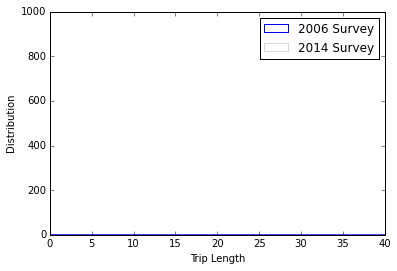

In [86]:
bins = 1000

P.hist(tourlen_scen, bins=bins, normed=True, histtype='step', color='b', label=scen_name)
P.hist(tourlen_base, bins=bins, normed=True, histtype='step', color='grey', alpha=0.3, label=base_name)
P.xlim([0,40])    # Cutting the tail at 40 to focus on shorter trip distribution
P.xlabel('Trip Length')
P.ylabel('Distribution')
P.legend()

## Tour Time

In [87]:
varname = 'Auto Distance'

tourtime_base = [i for i in tour_base[varname][:]]
tourtime_scen = [i for i in tour_scen[varname][:]]

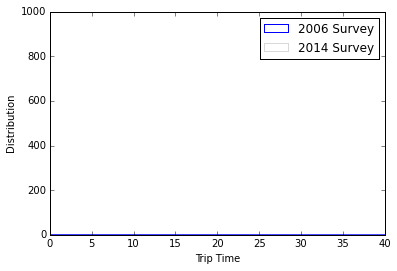

In [88]:
bins = 1000

P.hist(tourtime_scen, bins=bins, normed=True, histtype='step', color='b', label=scen_name)
P.hist(tourtime_base, bins=bins, normed=True, histtype='step', color='grey', alpha=0.3, label=base_name)
P.xlim([0,40])    # Cutting the tail at 40 to focus on shorter trip distribution
P.xlabel('Trip Time')
P.ylabel('Distribution')
P.legend()